<a href="https://colab.research.google.com/github/SAQUIBZEYA/ML_Project/blob/master/AirBnB_price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as conMatrix
from sklearn.metrics import classification_report as ClassR
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from uszipcode import Zipcode, SearchEngine
search = SearchEngine(simple_zipcode=True)

%matplotlib inline

# Load the datasets

In [ ]:
train_file=r'E:\saquib D.S\Data\mydata\AirBnB_train.csv'
test_file=r'E:\saquib D.S\Data\mydata\AirBnB_test.csv'

train_df=pd.read_csv(train_file)
test_df=pd.read_csv(test_file)

df=pd.concat([train_df,test_df],axis=0)

In [ ]:
df.head()

,id,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,log_price,
0,6901257,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.010635,NaN
1,6304928,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,5.129899,NaN
2,7919400,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,4.976734,NaN
3,13418779,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,...,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0,6.620073,NaN
4,3808709,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0,4.744932,NaN


# cleaning the datasets

In [ ]:
#check for missing values

missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
26,bedrooms,62
27,beds,91
12,host_has_profile_pic,127
13,host_identity_verified,127
15,host_since,127
5,bathrooms,146
25,zipcode,640
21,neighbourhood,4617
24,thumbnail_url,5595
17,last_review,10683


In [ ]:
#Handling missing values in both train and test dataframe

train_df['bathrooms'] = train_df['bathrooms'].fillna(0)
test_df['bathrooms'] = test_df['bathrooms'].fillna(0)

# 'bedrooms'
train_df['bedrooms'] = train_df['bedrooms'].fillna(0)
test_df['bedrooms'] = test_df['bedrooms'].fillna(0)

# 'beds' 
train_df['beds'] = train_df['beds'].fillna(0)
test_df['beds'] = test_df['beds'].fillna(0)

# 'host_has_profile_pic'
train_df.loc[train_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
train_df.loc[train_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
train_df['host_has_profile_pic'] = train_df['host_has_profile_pic'].fillna(0)
test_df.loc[test_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
test_df.loc[test_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
test_df['host_has_profile_pic'] = test_df['host_has_profile_pic'].fillna(0)

# 'neighbourhood'
train_df['neighbourhood'] = train_df['neighbourhood'].fillna('Unknown')
test_df['neighbourhood'] = test_df['neighbourhood'].fillna('Unknown')

# 'review_scores_rating'
train_df['review_scores_rating'] = train_df['review_scores_rating'].fillna(0)
test_df['review_scores_rating'] = test_df['review_scores_rating'].fillna(0)

# 'host_response_rate'
train_df['host_response_rate'] = train_df['host_response_rate'].str.replace('%','')
train_df['host_response_rate'] = train_df['host_response_rate'].fillna('0')
train_df['host_response_rate'] = pd.to_numeric(train_df['host_response_rate'])
test_df['host_response_rate'] = test_df['host_response_rate'].str.replace('%','')
test_df['host_response_rate'] = test_df['host_response_rate'].fillna('0')
test_df['host_response_rate'] = pd.to_numeric(test_df['host_response_rate'])
# 'thumbnai_url'
train_df['thumbnail_url'] = train_df['thumbnail_url'].fillna('Unknown')
test_df['thumbnail_url'] = test_df['thumbnail_url'].fillna('Unknown')

# 'last_review'
train_df['last_review'] = train_df['last_review'].fillna('00-00-00')
test_df['last_review'] = test_df['last_review'].fillna('00-00-00')

# 'first_review'
train_df['first_review'] = train_df['first_review'].fillna('00-00-00')
test_df['first_review'] = test_df['first_review'].fillna('00-00-00')

# 'host_since'
train_df['host_since'] = train_df['host_since'].fillna('00-00-00')
test_df['host_since'] = test_df['host_since'].fillna('00-00-00')

# 'host_identity_verified'
train_df.loc[train_df.host_identity_verified == 't', 'host_identity_verified'] = 1
train_df.loc[train_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
train_df['host_identity_verified'] = train_df['host_identity_verified'].fillna(0)
test_df.loc[test_df.host_identity_verified == 't', 'host_identity_verified'] = 1
test_df.loc[test_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
test_df['host_identity_verified'] = test_df['host_identity_verified'].fillna(0)

# 'zipcode', ***this might take some time, but works perfect***
train_df['zipcode'] = train_df['zipcode'].fillna(0)
train_df.loc[train_df.zipcode == ' ', 'zipcode'] = 0
idx = train_df.index[train_df['zipcode']==0].tolist()
for i in idx:
    lat = train_df['latitude'][i]
    lon = train_df['longitude'][i]
    result = np.max(search.by_coordinates(lat, lon, radius=30, returns=5))
    train_df['zipcode'][i]=result.values()[0]    
test_df['zipcode'] = test_df['zipcode'].fillna(0)
test_df.loc[test_df.zipcode == ' ', 'zipcode'] = 0
idx = test_df.index[test_df['zipcode']==0].tolist()
for i in idx:
    lat = test_df['latitude'][i]
    lon = test_df['longitude'][i]
    result = np.max(search.by_coordinates(lat, lon, radius=30, returns=5))
    test_df['zipcode'][i]=result.values()[0]

C:\Users\mdsha\anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mdsha\anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Again check for missing values in the test dataframe
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
29,,49999


In [ ]:
train_df['int_price'] = np.exp(train_df['log_price'])

# EXPLORATE DATA ANALYSIS (EDA)

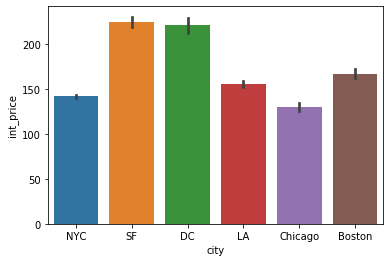

In [ ]:
#  plot1 Integer Pricing per City
plot1 = sns.barplot(x='city',y='int_price',data=train_df)
fig = plot1.get_figure()
fig.savefig('./plot1.png')

In [ ]:
#Plot 2: Average pricing for Property Type w.r.to City
train_df.pivot_table(values='int_price',index='property_type',columns='city')


city,Boston,Chicago,DC,LA,NYC,SF
property_type,,,,,,
Apartment,168.886029,121.995831,200.557457,123.046893,139.452941,215.783761
Bed & Breakfast,99.857143,83.090909,151.827586,101.832298,138.972603,165.218750
Boat,477.200000,301.428571,80.000000,202.764706,180.333333,606.333333
Boutique hotel,149.000000,209.571429,136.333333,92.000000,281.692308,155.833333
Bungalow,NaN,119.500000,172.500000,132.893878,159.000000,133.000000
Cabin,NaN,NaN,110.000000,96.146341,250.000000,145.333333
Camper/RV,NaN,NaN,NaN,138.051724,NaN,143.200000
Casa particular,NaN,NaN,NaN,80.000000,NaN,NaN
Castle,NaN,NaN,199.000000,285.833333,NaN,145.000000


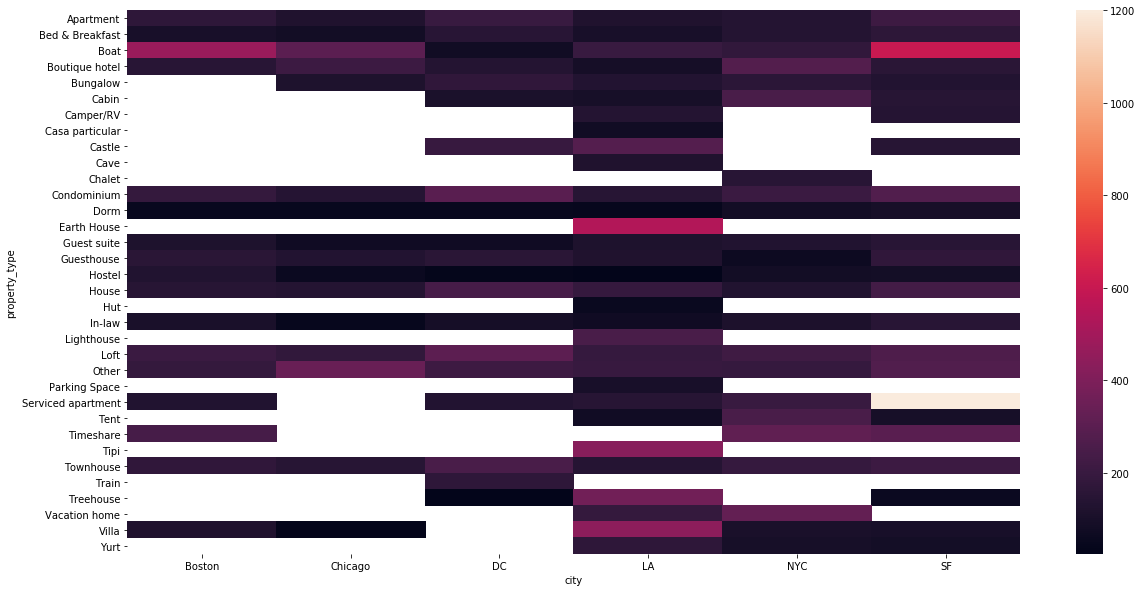

In [ ]:

plt.figure(figsize=(20,10))
pivot_df = train_df.pivot_table(values='int_price',index='property_type',columns='city')
plot2 = sns.heatmap(pivot_df)
fig = plot2.get_figure()
fig.savefig('./plot2.png')

# DATA PREPROCESSING

In [ ]:
train_df.to_csv('new_train.csv', encoding='utf-8', index=False)
test_df.to_csv('new_test.csv', encoding='utf-8', index=False)


In [ ]:
Rtrain_df = pd.read_csv('new_train.csv')
Rtest_df = pd.read_csv('new_test.csv')

In [ ]:
#Drop out features which has no effects on the pricing

Rtrain_df.drop(['int_price'], axis =1, inplace=True)

Rtrain_df.drop([' '],axis=1 ,inplace=True)
Rtest_df.drop([' '],axis=1 ,inplace=True)

Rtrain_df.drop(['id'], axis =1, inplace=True)
Rtest_df.drop(['id'], axis =1, inplace=True)

Rtrain_df.drop(['log_price'], axis =1, inplace=True)

Rtrain_df.drop(['neighbourhood'], axis =1, inplace=True)
Rtest_df.drop(['neighbourhood'], axis =1, inplace=True)

Rtrain_df.drop(['description'], axis =1, inplace=True)
Rtest_df.drop(['description'], axis =1, inplace=True)

Rtrain_df.drop(['first_review'], axis =1, inplace=True)
Rtest_df.drop(['first_review'], axis =1, inplace=True)

Rtrain_df.drop(['last_review'], axis =1, inplace=True)
Rtest_df.drop(['last_review'], axis =1, inplace=True)

Rtrain_df.drop(['host_since'], axis =1, inplace=True)
Rtest_df.drop(['host_since'], axis =1, inplace=True)

Rtrain_df.drop(['thumbnail_url'], axis =1, inplace=True)
Rtest_df.drop(['thumbnail_url'], axis =1, inplace=True)

Rtrain_df.drop(['zipcode'], axis =1, inplace=True)
Rtest_df.drop(['zipcode'], axis =1, inplace=True)

Rtrain_df.drop(['amenities'], axis =1, inplace=True)
Rtest_df.drop(['amenities'], axis =1, inplace=True)

Rtrain_df.drop(['name'], axis =1, inplace=True)
Rtest_df.drop(['name'], axis =1, inplace=True)

Rtrain_df.drop(['latitude'], axis =1, inplace=True)
Rtest_df.drop(['latitude'], axis =1, inplace=True)

Rtrain_df.drop(['longitude'], axis =1, inplace=True)
Rtest_df.drop(['longitude'], axis =1, inplace=True)

Rtrain_df.drop(['instant_bookable'], axis =1, inplace=True)
Rtest_df.drop(['instant_bookable'], axis =1, inplace=True)

In [ ]:

Rtrain_df.dtypes

property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
host_has_profile_pic        int64
host_identity_verified      int64
host_response_rate          int64
number_of_reviews           int64
review_scores_rating      float64
bedrooms                  float64
beds                      float64
dtype: object

In [ ]:
rtrain_df = Rtrain_df.copy()
rtest_df = Rtest_df.copy()
print(rtrain_df.shape)
print(rtest_df.shape)

(49999, 15)
(24111, 15)


# One Hot Encoding required features from Train and Test Data

In [ ]:
def one_hot(train_df,test_df,columns):
    
    for i,column in enumerate(columns):
        Xtrain = train_df[str(column)].T
        Xtest = test_df[str(column)].T
        
        # train_df
        lb=LabelBinarizer()
        lb.fit(Xtrain)
        X_classes = len(lb.classes_)
        Xenc = lb.transform(Xtrain)
        Xtrain_enc = pd.DataFrame(data = Xenc, columns = lb.classes_)
        train_df.drop([str(column)], axis =1, inplace=True)
        
        # test_df
        Xenc = lb.transform(Xtest)
        Xtest_enc = pd.DataFrame(data = Xenc, columns = lb.classes_)
        test_df.drop([str(column)], axis =1, inplace=True)
        
        print('Number of classes in '+str(column)+ ' = '+ str(X_classes))
        train_df = pd.concat((train_df,Xtrain_enc),axis=1)
        test_df = pd.concat((test_df,Xtest_enc),axis=1) 
    return train_df,test_df

In [ ]:
r_train_df , r_test_df = one_hot(rtrain_df,rtest_df,['city','property_type', 'room_type', 'bed_type', 'cancellation_policy', 'host_response_rate'])

Number of classes in city = 6
Number of classes in property_type = 34
Number of classes in room_type = 3
Number of classes in bed_type = 5
Number of classes in cancellation_policy = 5
Number of classes in host_response_rate = 77


In [ ]:
print(r_train_df.shape)
print(r_test_df.shape)

(49999, 139)
(24111, 139)


# FEATURE SELECTION

In [ ]:
#Principal Component Analysis (PCA)
pca = PCA()
pca_fit = pca.fit_transform(r_train_df)
pca_fit.shape

(49999, 139)

# MODEL IMPLEMENTATION

# Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error as rmse

In [ ]:
X = pca_fit
y = train_df['log_price']


In [ ]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
for train_idx, test_idx in kfold.split(X,y):    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
        
    pred_CV = lr.predict(X_CV)
    RMSE = rmse(y_CV, pred_CV)
    average = average + RMSE   
   
  print('RMSE = ',RMSE)

RMSE_AVG = average/10

print('*---------------------------*')
print('Average RMSE = ',RMSE_AVG)

RMSE =  0.21938948688645687
RMSE =  0.22570876351553384
RMSE =  0.2292291958406835
RMSE =  0.21908765666713362
RMSE =  2.03410051237892e+19
RMSE =  0.21936414906397358
RMSE =  0.22261605951477795
RMSE =  0.21965099381736167
RMSE =  6.086330946901121e+18
RMSE =  0.21801788460972799
*---------------------------*
Average RMSE =  2.6427336070690324e+18


# Ridge Regression

In [ ]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
for train_idx, test_idx in kfold.split(X,y):    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
        
    pred_CV = ridge.predict(X_CV)
    RMSE = rmse(y_CV, pred_CV)
    average = average + RMSE
 
    print('RMSE = ',RMSE)

RMSE_AVG = average/10

print('*---------------------------*')
print('Average RMSE = ',RMSE_AVG)

RMSE =  0.21938031771030683
RMSE =  0.22182574912623926
RMSE =  0.2291675389269997
RMSE =  0.21910970706396102
RMSE =  0.21803126804315298
RMSE =  0.21930881365042615
RMSE =  0.22244370454858844
RMSE =  0.21966036336260014
RMSE =  0.23106919601881892
RMSE =  0.2174496294012312
*---------------------------*
Average RMSE =  0.2217446287852325


# Lasso Regression

In [ ]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
for train_idx, test_idx in kfold.split(X,y):    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    lasso=Lasso(0.0001)
    lasso.fit(X_train, y_train)
        
    pred_CV = lasso.predict(X_CV)
    RMSE = rmse(y_CV, pred_CV)
    average = average + RMSE

   
    print('RMSE = ',RMSE)

RMSE_AVG = average/10

print('*---------------------------*')
print('Average RMSE = ',RMSE_AVG)

RMSE =  0.22015440074263612
RMSE =  0.22222456921096922
RMSE =  0.2290904700286781
RMSE =  0.2195344125537014
RMSE =  0.2174233719475952
RMSE =  0.21901047368468157
RMSE =  0.22223615962294452
RMSE =  0.21994129900081524
RMSE =  0.23104205121981136
RMSE =  0.217068506683371
*---------------------------*
Average RMSE =  0.22177257146952037


# GRID SEARCH TECHNIQUE

In [ ]:
parameters = {"alpha":np.logspace(-2,2,50)}
lasso_grid = GridSearchCV(lasso, parameters, cv=10) 
lasso_grid.fit(X,y)

print('Hyper Parameters for Lasso:\n',lasso_grid.best_params_)
print('Score for Hyper Parameters from Grid Search:',lasso_grid.best_score_)
lasso_grid.cv_results_

Hyper Parameters for Lasso:
 {'alpha': 0.01}
Score for Hyper Parameters from Grid Search: 0.5332518382155854


{'mean_fit_time': array([0.22503929, 0.22164326, 0.21883564, 0.2258842 , 0.25473905,
        0.25576091, 0.27338524, 0.25531483, 0.22057076, 0.24127007,
        0.23158114, 0.23939612, 0.2316097 , 0.21792128, 0.2560288 ,
        0.29231832, 0.33435686, 0.28279796, 0.28136172, 0.25383832,
        0.23331056, 0.23642211, 0.21979029, 0.21221378, 0.21573298,
        0.22798152, 0.21916957, 0.21125209, 0.22012837, 0.22972469,
        0.21957247, 0.25038688, 0.22927039, 0.20775414, 0.23255308,
        0.27225051, 0.21244805, 0.24502432, 0.24680929, 0.26827767,
        0.22466848, 0.22937012, 0.2403502 , 0.23398206, 0.28552864,
        0.25786226, 0.25832307, 0.28567519, 0.27580104, 0.27660646]),
 'std_fit_time': array([0.01883192, 0.00892381, 0.01242344, 0.01613811, 0.01908546,
        0.01925009, 0.02536037, 0.01937882, 0.01900088, 0.02565392,
        0.02613868, 0.02073874, 0.01554568, 0.01898088, 0.01786863,
        0.03334551, 0.03839448, 0.01695973, 0.0213578 , 0.0296771 ,
        0.027

In [ ]:
pca0 = PCA()
pca0.fit(r_train_df)
X_train = pca0.transform(r_train_df)
y_train = train_df['log_price']

X_test = pca0.transform(r_test_df)

In [ ]:
lasso = Lasso(0.0001)
lasso.fit(X_train, y_train)

# Prices predicted for test dataset is given by 'price_predicted'
price_predicted = lasso.predict(X_test)

In [ ]:
print(price_predicted)

[4.4240304  4.91021681 4.48167154 ... 5.21379259 4.85883573 5.21390811]


In [ ]:
pred= pd.DataFrame(price_predicted,columns=['log_price'])

In [ ]:
pred

,log_price
0,4.424030
1,4.910217
2,4.481672
3,4.231582
4,5.087600
...,...
24106,4.401250
24107,5.071302
24108,5.213793
24109,4.858836


In [ ]:
pred.to_csv('submission.csv',index_label='id')